In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Movie-Data.csv', usecols=['Genre','Description'])
data.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


In [2]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [3]:
data.duplicated().sum()

0

<Axes: ylabel='Frequency'>

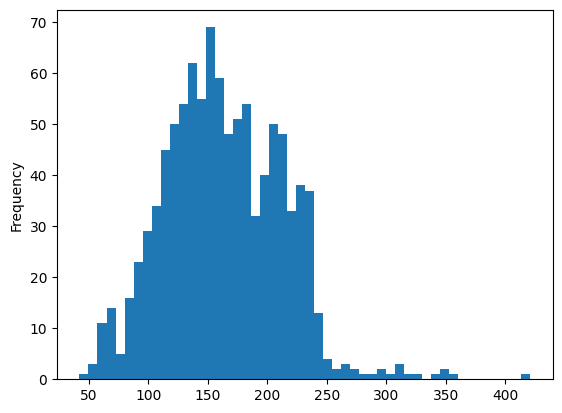

In [4]:
data['Description'].str.len().plot.hist(bins= 50)

In [5]:
data['Genre'] = data['Genre'].str.split(',')

In [6]:
Genre_counts = [j for i in data['Genre'] for j in i] 
pd.Series(Genre_counts).value_counts()

Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Sport         18
Music         16
War           13
Western        7
Musical        5
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(data['Genre']).astype('float32')
texts = data['Description'].tolist()

In [26]:
texts[:5]

['A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.',
 'Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.',
 'Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.',
 "In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",
 'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.']

In [8]:
! pip install -U accelerate
! pip install -U transformers


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(data['Genre']).astype('float32')
texts = data['Description'].tolist()

In [10]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

C:\Users\Ajay Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts,labels, test_size=0.2, random_state=42)

In [11]:
# Define your model checkpoint
checkpoint = 'distilbert-base-uncased'

# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }


In [15]:
# Initialize train and validation datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [17]:
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average='samples')
    roc_auc = roc_auc_score(y_true, y_pred, average='samples')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
        'roc_auc': roc_auc,
        'hamming_loss': hamming,
        'f1': f1
    }

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

    result = multi_labels_metrics(predictions=preds,
                                  labels=p.label_ids)

    return result

In [18]:
from transformers import Trainer
from transformers import TrainingArguments,Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps = 1000,
    save_total_limit = 2)
# Trainer initialization
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Include compute_metrics function here
)

# Training
trainer.train()


C:\Users\Ajay Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,0.257300


TrainOutput(global_step=500, training_loss=0.2573364562988281, metrics={'train_runtime': 2911.3612, 'train_samples_per_second': 1.374, 'train_steps_per_second': 0.172, 'total_flos': 132509921280000.0, 'train_loss': 0.2573364562988281, 'epoch': 5.0})

In [19]:
  trainer.evaluate()

{'eval_loss': 0.23767796158790588,
 'eval_roc_auc': 0.8023108015135878,
 'eval_hamming_loss': 0.10025,
 'eval_f1': 0.6166904761904761,
 'eval_runtime': 47.963,
 'eval_samples_per_second': 4.17,
 'eval_steps_per_second': 0.521,
 'epoch': 5.0}

In [20]:
## predictions
text = 'A young man seeks vengence for the death of his teacher.'
encoding = tokenizer(text, return_tensors='pt')
outputs = trainer.model(**encoding)


In [21]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0])

In [22]:
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1


In [23]:
multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('Comedy', 'Drama')]